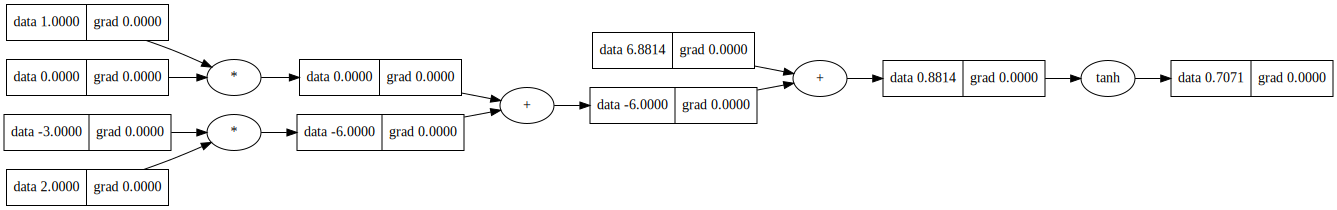

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Define a class Value
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self.grad = 0.0 # gradient, which is zero initially
        self._backward = lambda: None # by default, this is set to an empty function lambda which does nothing
        self._prev = set(_children) # set of previous values kept for efficiency in backprop
        self._op = _op # operation that created this value
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other) # this enables adding non Value objects to a value object by converting it to a Value object first
        out =  Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad # from chain rule
        out._backward = _backward
        return out

    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float for powers for now"
        out = Value(self.data**other,(self,),f'**{other}')
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad # nx^(n-1) is the derivative of power
        out._backward = _backward
        return out

    def __rmul__(self,other): # it enables multiplying a Value object by a non Value object when the non Value object is first, which otherwise would register a non Value object as self.
        return self * other

    def __radd__(self,other): # it enables multiplying a Value object by a non Value object when the non Value object is first, which otherwise would register a non Value object as self.
        return self + other

    def __truediv__(self,other): # self/other
        return self * other**-1 # this is the same as multiplying by the inverse, therefore mimics division

    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        return self + (-other) # this is the same as adding the negative of the other value


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1) # this is an expression that equals tanh
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad # because of the chain rule
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,) ,'exp')
        def _backward():
            self.grad = out.data * out.grad # because the derivative of exp(x) is exp(x)
        out._backward = _backward   
        return out  


    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()






# define a function using graphviz to visualize the graph produced
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

# make a single neuron graph
# Adding the sigmoid function to the graph
x1 = Value(2.0, label='x1')
x2 = Value(0.0,label='x2')
# Neuron weights, w1, w2 which are the synaptic strength of the neurons
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# a neuron's bias
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# add the activation function
o = n.tanh()

draw_dot(o)

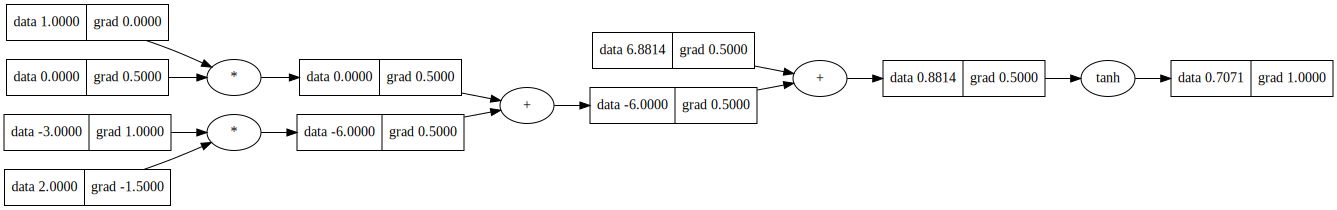

In [12]:
o.backward()
draw_dot(o)

In [13]:
a  = Value(2.0)
b  = Value(4.0)
a-b

Value(-2.0)

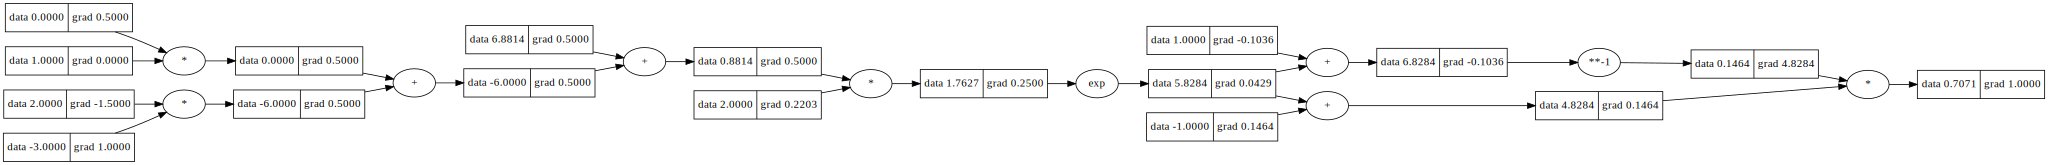

In [14]:

# make a single neuron graph
# Adding the sigmoid function to the graph
x1 = Value(2.0, label='x1')
x2 = Value(0.0,label='x2')
# Neuron weights, w1, w2 which are the synaptic strength of the neurons
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# a neuron's bias
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# add the activation function
e = (2*n).exp()
o = (e-1) / (e+1)
o.label = 'o'

o.backward()

draw_dot(o)


In [15]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad=True # we have tensor representation but we have implemented a scalar function in ours
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad=True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print( o.data.item() ) # prints forward pass
o.backward() # prints backward pass

print('---')
print('x1',x1.grad.item())
print('w1',x2.grad.item())
print('x2',w1.grad.item())
print('w2',w2.grad.item())


0.7071066904050358
---
x1 -1.5000003851533106
w1 0.5000001283844369
x2 1.0000002567688737
w2 0.0


In [16]:
x2.grad.item()

0.5000001283844369

In [104]:
import random
class Neuron:

    def __init__(self, nin ):
        self.w  = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b  = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b) # the sum starts with self.b as its initial value as its the second argument to sum function
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b] # make a list of all the weights and the bias, i.e., the neuron's parameters


class Layer:
    
    def __init__(self, nin, nout):  # nout is the number of outputs, i.e., the number of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # for each neuron in the layer, we pass the input x into the neuron and get the output 
        return outs[0] if len(outs) == 1 else np.array(outs)
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] #for each neuron in the layer, we get the parameters of the neuron and make a list of all the parameters
        
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x): # what happens when it is called
        for layer in self.layers: # for each layer in the layers
            x = layer(x) # we pass the input x into the layer and get the output
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] # for each layer in the layers, we get the parameters of the layer and make a list of all the parameters

#x = [2.0, 3.0,-1.0]
#n1 = Neuron(2)
#n2= Layer(2,3) # instead of making a single neuron, we make a layer of neurons
#n = MLP(3, [4,4,1]) # 3 inputs into 2 layers of 4

x = [2.0, 3.0, -1] # three inputs
n = MLP(3, [4,4,1]) # three input MLP with 2 middle layers of 4 neurons each and one output layer of 1 neuron.

n(x)

len(n.parameters()) # total number of parameters in the network
#draw_dot(n(x))



41

In [68]:
# set up inputs and desired outputs
xs = [[2.0, 3.0,-1.0], [1.0, 2.0, 3.0], [0.0, 1.0, 2.0], [1.0,1.0,-1.0]] # set up inputs. 4 inputs, three each for three neurons
ys = [-1.0, 1.0, 1.0, -1.0] # set up outputs. 4 outputs, one each for each input, i.e., the desired outputs that the MLP should produce


-0.28053795848960306

In [90]:
# perform a prediction, calculate the loss, perform a backpropagation step and evaluate the first neuron of the first layer
ypred = [n(x) for x in xs] # perform a prediction
# setup up the mean squared error loss function
mse_loss = sum([(yout - ygt)**2 for yout,ygt in zip(ypred,ys)])
mse_loss


Value(0.008482106190104444)

In [91]:
mse_loss.backward() # perform backpropagation

n.layers[0].neurons[0].w[0].grad # check if there is a gradient for the first weight of the first neuron of the first layer
n.layers[0].neurons[0].w[0].data # output the value of the first weight of the first neuron of the first layer
#draw_dot(mse_loss)


0.07631354141878775

In [92]:
# update the parameters, i.e., the weights and the biases of the neural network
for p in n.parameters():
    lrate = 0.01 # learning rate
    p.data += -lrate * p.grad # update the parameters by premultiplying with a learning rate. The negative sign is because we want to go in the direction of the negative gradient, i.e., the direction of the steepest descent

n.layers[0].neurons[0].w[0].data # output the value of the first weight of the first neuron of the first layer after the update

0.1260799747945736

In [108]:
# now do this in a loop to make it more mature

x = [2.0, 3.0, -1] # three inputs
n = MLP(3, [4,4,1]) # three input MLP with 2 middle layers of 4 neurons each and one output layer of 1 neuron.


for k in range(100):
    # forward pass
    ypred = [n(x) for x in xs] # perform a prediction
    mse_loss = sum([(yout - ygt)**2 for yout,ygt in zip(ypred,ys)]) # calculate the loss
    # convert all gradients to zero else they all stack up using the += operator
    for p in n.parameters():
        p.grad = 0
    # backward pass
    mse_loss.backward() # perform backpropagation
    # update the parameters
    for p in n.parameters():
        lrate = 0.05
        p.data += -lrate * p.grad # update the parameters by premultiplying with a learning rate. The negative sign is because we want to go in the direction of the negative gradient, i.e., the direction of the steepest descent
    
    print(mse_loss.data, '\n')



7.941901625574995 

7.941298384193745 

7.940682576995402 

7.940053808660592 

7.939411667165822 

7.93875572289457 

7.938085527691202 

7.937400613853364 

7.936700493058137 

7.935984655216867 

7.935252567253075 

7.9345036717973905 

7.93373738579284 

7.932953099003321 

7.9321501724172805 

7.931327936538004 

7.930485689550994 

7.929622695358055 

7.9287381814666995 

7.9278313367223445 

7.926901308869469 

7.9259472019266575 

7.924968073358699 

7.923962931027373 

7.922930729900483 

7.921870368496603 

7.920780685040545 

7.919660453301858 

7.918508378085566 

7.917323090340962 

7.9161031418503525 

7.91484699945528 

7.913553038772809 

7.912219537348809 

7.910844667188855 

7.9094264866001165 

7.907962931269327 

7.906451804492618 

7.904890766462205 

7.903277322502685 

7.901608810135584 

7.899882384834617 

7.898095004315551 

7.8962434111829145 

7.894324113731091 

7.892333364668363 

7.8902671374990625 

7.888121100259902 

7.8858905862610635 

7.88357056142